# Filter Data from INKAR

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import mapclassify

```
Erstveröffentlichung der INKAR-Aktualisierung am 28.01.2022.
Vorliegender korrigierter Datenstand Mai 2022.

Die INKAR-Daten liegen zeitreihenbereinigt auf dem Gebietsstand 31.12.2019 vor.
Im Themenbereich Europa wird die NUTS-Klassifikation 2016 genutzt.
Weiterführende Informationen (z.B. eine Erläuterung der Raumabgrenzungen) finden Sie unter www.Raumbeobachtung.de.

Datensatzbeschreibung
Feldseperator: ;
Dezimalzeichen: ,
Missing:
Spaltenüberschriften: Ja

Aufgrund der Größe (entpackt ~2GB) kann es beim Öffnen der CSV-Datei mit Excel oder dem Texteditor Probleme geben.
Vorgesehen ist die Nutzung dieser Gesamtdatei über Programmiersprachen wie bspw. R oder Python.

Für INKAR existiert ein inoffizielles nutzererstelltes R-Paket namens "bonn" (https://github.com/sumtxt/bonn).
```

In [3]:
inkar = pd.read_csv("../../_data/inkar_2022/inkar_2022.zip", compression='zip',sep=";",decimal=",",dtype={'Kennziffer':str,'Kennziffer_EU':str,'Name':str}, low_memory=False)
inkar.head()

,Bereich,ID,Indikator,Raumbezug,Kennziffer,Name,Zeitbezug,Wert
0,Absolutzahlen,2176,Arbeitslose,Arbeitsmarktregionen,001,Flensburg,1995,10494.0
1,Absolutzahlen,2176,Arbeitslose,Arbeitsmarktregionen,001,Flensburg,1996,11921.0
2,Absolutzahlen,2176,Arbeitslose,Arbeitsmarktregionen,001,Flensburg,1997,13213.0
3,Absolutzahlen,2176,Arbeitslose,Arbeitsmarktregionen,001,Flensburg,1998,13301.0
4,Absolutzahlen,2176,Arbeitslose,Arbeitsmarktregionen,001,Flensburg,1999,12048.0


In [12]:
# alle Kennziffer-Codes ausgeben
geo_codes = inkar[["Raumbezug","Kennziffer","Name"]].copy().sort_values(by=["Raumbezug","Kennziffer"]).drop_duplicates()
with pd.ExcelWriter("kennziffern.xlsx") as writer:
    for r in (geo_codes['Raumbezug'].unique()):
        print(sheet_name=r[0:30].strip('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'))
        geo_codes[geo_codes['Raumbezug']==r].to_excel(writer, sheet_name=r[0:30].strip('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'), index=False)

IndexError: At least one sheet must be visible

In [ ]:
#appID = "maplegend"
appID = "CHDC"
raumbezug_selection = ["Kreise","Gemeinden"]
indikator_selection = [
    'Lebenserwartung',
    #'Arbeitslosenquote','Zuzugsrate','Fortzugsrate',
    #'Schulabgänger ohne Abschluss',
    #'Einwohnerdichte',
    #'Krankenhausversorgung',
    #'SGB II - Quote', 
    #'Empfänger von Grundsicherung im Alter (Altersarmut)',
    #'Bruttoinlandsprodukt in 1000 Euro', 
    #'Bruttoinlandsprodukt je Erwerbstätigen',
    'Bruttoinlandsprodukt je Einwohner',
    #'Bruttoinlandsprodukt je Einwohner in Kaufkraftstandards (KKS)',
    #'Säuglingssterblichkeit (<1 Jahr)',
    'Restlebenserwartung der 60-Jährigen',
    'Pendlersaldo',
    'Krankenhausbetten je 1000 Einwohner'
    ]
zeitbezug_selection = ['2017','2018','2019']

In [ ]:
raumbezug = pd.Series(geo_codes['Raumbezug'].unique())
raumbezug.to_json("./out/raumbezug.json")
raumbezug[raumbezug.isin(raumbezug_selection)].to_json("./out/raumbezug_reduced.json")

In [ ]:
temp = inkar[inkar['Raumbezug'].isin(raumbezug_selection)]
temp = temp[temp['Indikator'].isin(indikator_selection)]
temp = temp[temp['Zeitbezug'].isin(zeitbezug_selection)]
len(temp)




45115

In [ ]:
#pd.Series(temp.Indikator.unique()).to_json("./out/indicators.json")
menu = temp[['Bereich','Indikator']].drop_duplicates(ignore_index=True)
#menu.to_csv("./out/indicators.csv")

In [ ]:
menu = temp.groupby(['Bereich','Indikator','ID']).aggregate({'Zeitbezug':['min','max']})
menu.columns = ["_".join(a) for a in menu.columns.to_flat_index()]
menu = menu.merge(temp.pivot_table(index=['Bereich','Indikator','ID'], columns='Raumbezug',values='Kennziffer',aggfunc=np.count_nonzero),left_index=True,right_index=True)
menu['Gemeinden'] = menu['Gemeinden']>0
menu['Kreise'] = menu['Kreise']>0
menu.reset_index().to_csv("./out/"+appID+"/indicators.csv",index=False)#,index_label='row')
indicatorIDs = temp.ID.unique()
for id in indicatorIDs:
    temp[temp.ID==id][['Kennziffer','Zeitbezug','Wert']].to_csv("./out/"+appID+"/"+str(id)+".csv",index=False)
menu

Zeitbezug_min  \
Bereich                    Indikator                           ID                  
Bevölkerung                Lebenserwartung                     182          2017   
                           Restlebenserwartung der 60-Jährigen 183          2017   
SDG                        Bruttoinlandsprodukt je Einwohner   398          2017   
Verkehr und Erreichbarkeit Pendlersaldo                        353          2017   
Wirtschaft                 Bruttoinlandsprodukt je Einwohner   365          2017   
ZOM                        Krankenhausbetten je 1000 Einwohner 482          2019   
                           Pendlersaldo                        451          2017   

                                                                   Zeitbezug_max  \
Bereich                    Indikator                           ID                  
Bevölkerung                Lebenserwartung                     182          2019   
                           Restlebenserwartung der 60-Jährigen 183          2019   
SDG                        Bruttoinlandsprodukt je Einwohner   398          2019   
Verkehr und Erreichbarkeit Pendlersaldo                        353          2019   
Wirtschaft                 Bruttoinlandsprodukt je Einwohner   365          2019   
ZOM                        Krankenhausbetten je 1000 Einwohner 482          2019   
                           Pendlersaldo                        451          2019   

                                                                    Gemeinden  \
Bereich                    Indikator                           ID               
Bevölkerung                Lebenserwartung                     182      False   
                           Restlebenserwartung der 60-Jährigen 183      False   
SDG                        Bruttoinlandsprodukt je Einwohner   398      False   
Verkehr und Erreichbarkeit Pendlersaldo                        353      False   
Wirtschaft                 Bruttoinlandsprodukt je Einwohner   365      False   
ZOM                        Krankenhausbetten je 1000 Einwohner 482       True   
                           Pendlersaldo                        451       True   

                                                                    Kreise  
Bereich                    Indikator                           ID           
Bevölkerung                Lebenserwartung                     182    True  
                           Restlebenserwartung der 60-Jährigen 183    True  
SDG                        Bruttoinlandsprodukt je Einwohner   398    True  
Verkehr und Erreichbarkeit Pendlersaldo                        353    True  
Wirtschaft                 Bruttoinlandsprodukt je Einwohner   365    True  
ZOM                        Krankenhausbetten je 1000 Einwohner 482   False  
                           Pendlersaldo                        451   False

In [ ]:
menu.to_json("./out/"+appID+"/menu.json",orient="records")#, lines=True)

OEGD-PageConfig-Format

```json
{
    "code":"",
    "caption":"",
    "source":"",
    "geodimPrimary":"",
    "geodimSecondary":"",
    "indicatorConfigs":[
        {
            "code":"",
            "caption":"",
            "filename":"",
            "text":"",
        }
    ]
}
```

In [ ]:
for Bereich, indicators in menu.groupby(level=0):
    print(Bereich)
    for Indicator, indParams in indicators.groupby(level=1):
        print("  ",Indicator, indParams.loc[pd.IndexSlice[["ID"],:],:])

Bevölkerung
   Lebenserwartung Empty DataFrame
Columns: [Zeitbezug_min, Zeitbezug_max, Gemeinden, Kreise]
Index: []
   Restlebenserwartung der 60-Jährigen Empty DataFrame
Columns: [Zeitbezug_min, Zeitbezug_max, Gemeinden, Kreise]
Index: []
SDG
   Bruttoinlandsprodukt je Einwohner Empty DataFrame
Columns: [Zeitbezug_min, Zeitbezug_max, Gemeinden, Kreise]
Index: []
Verkehr und Erreichbarkeit
   Pendlersaldo Empty DataFrame
Columns: [Zeitbezug_min, Zeitbezug_max, Gemeinden, Kreise]
Index: []
Wirtschaft
   Bruttoinlandsprodukt je Einwohner Empty DataFrame
Columns: [Zeitbezug_min, Zeitbezug_max, Gemeinden, Kreise]
Index: []
ZOM
   Krankenhausbetten je 1000 Einwohner Empty DataFrame
Columns: [Zeitbezug_min, Zeitbezug_max, Gemeinden, Kreise]
Index: []
   Pendlersaldo Empty DataFrame
Columns: [Zeitbezug_min, Zeitbezug_max, Gemeinden, Kreise]
Index: []


# Schönen Urlab gehabt?

Mach hier weiter, exportiere den Datensatz und bau Ihn zur Auswahl über ein Dropdown-Feld in das Projekt **Maplegend** ein.

In dem Projekt baust Du eine Themenauswahl ein und imporiterst die CSVs.

Dann baust Du einen Split-View (Links / rechts) wo man getrennte Daten auswählen kann.

Eine Möglichkeit wäre es dann, für die Niederlande vergleichbare Daten zu suchen.

In [ ]:
inkar['Jahresnummer']=inkar[inkar['Zeitbezug'].str.isnumeric()].Zeitbezug.astype(np.int32)#, errors="ignore")
#inkar[~inkar['Jahresnummer'].str.isnumeric()]['Jahresnummer'] = np.NaN
#inkar['Jahresnummer']=inkar.Jahresnummer.astype(np.int32)
inkar.dtypes

Bereich           object
ID                 int64
Indikator         object
Raumbezug         object
Kennziffer        object
Kennziffer_EU     object
Name              object
Zeitbezug         object
Wert             float64
Jahresnummer     float64
dtype: object

In [ ]:
inkar.Bereich.unique()

array(['Absolutzahlen', 'Arbeitslosigkeit', 'Bauen und Wohnen',
       'Beschäftigung und Erwerbstätigkeit', 'Bevölkerung', 'Bildung',
       'Privateinkommen, Private Schulden', 'Flächennutzung und Umwelt',
       'Medizinische und soziale Versorgung', 'Öffentliche Finanzen',
       'Raumwirksame Mittel', 'Siedlungsstruktur', 'Sozialleistungen',
       'Verkehr und Erreichbarkeit', 'Wirtschaft', 'ZOM', 'SDG', 'Europa'],
      dtype=object)

In [ ]:
inkar.Raumbezug.unique()

array(['Bund', 'West-Ost', 'Bundesländer', 'Kreise', 'Regierungsbezirke',
       'Kreisregionen', 'Raumordnungsregionen', 'Arbeitsmarktregionen',
       'Braunkohlerevier', 'Siedlungsstruktureller Regionstyp',
       'Siedlungsstruktureller Regionstyp (Bundesländer)',
       'Siedlungsstruktureller Regionstyp (West-Ost))',
       'Siedlungsstrukturelle Kreistyp',
       'Siedlungsstruktureller Kreistyp (Bundesländer)',
       'Siedlungsstruktureller Kreistyp (West-Ost)',
       'Städtischer-Ländlicher Raum',
       'Städtischer-Ländlicher Raum (Bundesländer)',
       'Städtischer-Ländlicher Raum (West-Ost)',
       'Raumtyp Bezug Lage (Kreise)', 'Wachsen-Schrumpfen (Kreise)',
       'Gemeindeverbände', 'BBSR-Mittelbereiche', 'Großstadtregionen',
       'Großstadtregionaler Einzugsbereich', 'IHK-Bezirke',
       'Stadt- und Gemeindetyp', 'Stadt- und Gemeindetyp (West-Ost)',
       'Stadt und Gemeindetyp (Bundesländer)',
       'Stadt- und Gemeindetyp differenziert',
       'Raumtyp Bezu

In [ ]:
inkar.Indikator.unique()

array(['Arbeitslose',
       'sozialversicherungspflichtig Beschäftigte am Arbeitsort',
       'sozialversicherungspflichtig Beschäftigte am Wohnort',
       'Bevölkerung gesamt', 'Bevölkerung männlich',
       'Bevölkerung weiblich',
       'Erwerbsfähige Bevölkerung (15 bis unter 65 Jahre)',
       'Bevölkerung (mit Korrektur VZ 1987/Zensus 2011)',
       'Bodenfläche gesamt', 'Bruttoinlandsprodukt in 1000 Euro',
       'Arbeitslosenquote', 'Arbeitslosenquote Frauen',
       'Arbeitslose Frauen', 'Arbeitslosenquote Männer',
       'Arbeitslose Männer', 'ausländische Arbeitslose',
       'ausländische weibliche Arbeitslose',
       'ausländische männliche Arbeitslose',
       'Arbeitslose ohne Ausbildung',
       'Arbeitslose mit Anforderungsniveau Experte',
       'Arbeitslose mit Anforderungsniveau Spezialist',
       'Arbeitslose mit Anforderungsniveau Fachkraft',
       'Arbeitslose mit Anforderungsniveau Helfer',
       'Offene Stellen mit Anforderungsniveau Experte',
       'Off

In [ ]:
# Testauszug
code = "3403"
auszug = inkar[(inkar.Kennziffer.str.match(code+".*")==True)]
with pd.ExcelWriter("auszug_"+code+".xlsx") as writer:
    for r in (auszug['Raumbezug'].unique()):
        auszug[auszug['Raumbezug']==r].to_excel(writer, sheet_name=r[0:30], index=False)

In [ ]:
# 11 min
def hasMatch(needle:str, haystack=[]):
    found = False
    for straw in haystack:
       found =  needle.startswith(straw)
       if (found):
            return found
    return found


def selectRegion(r, kennziffern=[], strict=True):
    selected = False
    if (strict):
        selected = np.isin(element=r, test_elements=kennziffern)
    else:
        selected = hasMatch(str(r), kennziffern)
    return selected

# /11min

kennziffern = ['3402','3403','3405','3451','3452','3453','3454','3455','3456','3457','3458','3460','3461','3462']
# findet nur angegebene Kennziffern
patternStrict = '^' + '$|^'.join(kennziffern)+ '$'
# findet z.B. auch Gemeinden, dh mit Kennziffern beginnende Muster
patternMatch = '.*|'.join(kennziffern) + '.*'

inkar['selected'] = inkar['Kennziffer'].str.match(patternStrict) # is already loose match
print(inkar[inkar.selected==True].count(), "selected")
region = inkar[inkar.selected==True]# inkar[np.isin(element=inkar['Kennziffer'], test_elements=kennziffern)]
#region

Bereich          83248
ID               83248
Indikator        83248
Raumbezug        83248
Kennziffer       83248
Kennziffer_EU        0
Name             83248
Zeitbezug        83248
Wert             83248
Jahresnummer     83038
selected         83248
dtype: int64 selected


[ 7.99 23.19 34.33 48.14 69.61] [ 87 112 115  59  28]


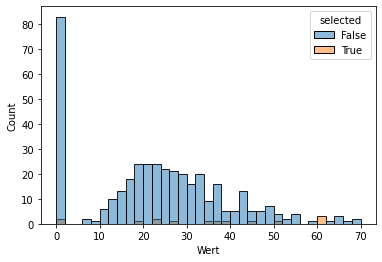

In [ ]:
# Raumtyp nach Lage (nicht auf Kreisen)
kategorie_indikator = "Erreichbarkeit von Oberzentren"
kategorie = inkar[(inkar.Indikator==kategorie_indikator)&(inkar.Raumbezug=='Kreise')]
if (len(kategorie.Zeitbezug.unique())>1): print("ACHTUNG! ZEITBEZUG FILTERN!")
sns.histplot(data = kategorie, x="Wert", hue="selected", binwidth=2)
kategorie = kategorie[['Kennziffer','Wert']]
classification = mapclassify.FisherJenks(kategorie['Wert'])
#classification = mapclassify.Percentiles(kategorie['Wert'], pct=[33,66,100])
print(classification.bins, classification.counts)#, classification.get_legend_classes())
kategorie['Klasse'] = kategorie['Wert'].apply(classification.find_bin)
kategorie['Klasse'] = kategorie['Klasse'].astype(int)

inkar = inkar.merge(right=kategorie, left_on="Kennziffer", right_on="Kennziffer", suffixes=(None,"_kat")).rename(
    columns={'Wert_kat':kategorie_indikator,'Klasse_kat':'Klasse'}
    )

#inkar[kategorie_indikator]=kategorie.Wert


<AxesSubplot:xlabel='Wert', ylabel='Count'>

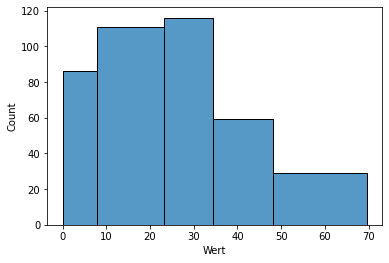

In [ ]:
bins = [0]
bins.extend(classification.bins)
sns.histplot(data = kategorie, x="Wert", bins=bins) #binwidth=2, hue="Klasse",

In [ ]:

ind = inkar[np.isin(element=inkar['Indikator'], test_elements=indikatoren)]
ind

,Bereich,ID,Indikator,Raumbezug,Kennziffer,Kennziffer_EU,Name,Zeitbezug,Wert,Jahresnummer,selected,Erreichbarkeit von Oberzentren,Klasse
422,Absolutzahlen,10,Bruttoinlandsprodukt in 1000 Euro,Kreise,1001,NaN,"Flensburg, Stadt",2000,2487282.00,2000.0,False,0.00,0
423,Absolutzahlen,10,Bruttoinlandsprodukt in 1000 Euro,Kreise,1001,NaN,"Flensburg, Stadt",2001,2465393.00,2001.0,False,0.00,0
424,Absolutzahlen,10,Bruttoinlandsprodukt in 1000 Euro,Kreise,1001,NaN,"Flensburg, Stadt",2002,2635779.00,2002.0,False,0.00,0
425,Absolutzahlen,10,Bruttoinlandsprodukt in 1000 Euro,Kreise,1001,NaN,"Flensburg, Stadt",2003,2705233.00,2003.0,False,0.00,0
426,Absolutzahlen,10,Bruttoinlandsprodukt in 1000 Euro,Kreise,1001,NaN,"Flensburg, Stadt",2004,2867823.00,2004.0,False,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391385,SDG,398,Bruttoinlandsprodukt je Einwohner,Kreise,16077,NaN,Altenburger Land,2015,19.96,2015.0,False,31.49,2
2391386,SDG,398,Bruttoinlandsprodukt je Einwohner,Kreise,16077,NaN,Altenburger Land,2016,20.96,2016.0,False,31.49,2
2391387,SDG,398,Bruttoinlandsprodukt je Einwohner,Kreise,16077,NaN,Altenburger Land,2017,21.77,2017.0,False,31.49,2
2391388,SDG,398,Bruttoinlandsprodukt je Einwohner,Kreise,16077,NaN,Altenburger Land,2018,22.16,2018.0,False,31.49,2


In [ ]:
def group(row, groupValue=5):
    if (row['selected'] == True):
        if (row[kategorie_indikator] < groupValue):
            return "EDR Oberzentrum"
        else:
            return "EDR Rest"
    if (row.selected == False):
        if (row[kategorie_indikator] < groupValue):
            return "DE Oberzentrum"
        else:
            return "DE Rest"


def EDR(row):
    if (row['selected'] == True):
        return "EDR"
    if (row.selected == False):
        return "DE"

kategorie_grenzwert = classification.bins[0]
ind['group'] = ind.apply(group, groupValue=kategorie_grenzwert, axis=1)
ind['EDR'] = ind.apply(EDR, axis=1)


C:\Users\sSpecht\AppData\Local\Temp/ipykernel_21080/1109212959.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind['group'] = ind.apply(group, groupValue=kategorie_grenzwert, axis=1)
C:\Users\sSpecht\AppData\Local\Temp/ipykernel_21080/1109212959.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind['EDR'] = ind.apply(EDR, axis=1)


In [ ]:
# Excel-Export eines einzelnen Indikators
ind_filter = 'Restlebenserwartung der 60-Jährigen'
ind_export = ind[(ind.Indikator==ind_filter)&(ind.Jahresnummer==2019)&(ind.Raumbezug=='Kreise')&(ind[kategorie_indikator]>0)]
#ind_export.to_excel("auszug_"+ind_filter+".xlsx", index=False)

In [ ]:
print(ind_export[[kategorie_indikator,'Wert']].corr())
res = ind_export[kategorie_indikator].sub(ind_export['Wert']).pow(2).sum()
tot = ind_export[kategorie_indikator].sub(ind_export[kategorie_indikator].mean()).pow(2).sum()
r2 = 1 - res/tot
print('r²',r2)

                                Erreichbarkeit von Oberzentren      Wert
Erreichbarkeit von Oberzentren                        1.000000 -0.303704
Wert                                                 -0.303704  1.000000
r² -0.27542461916229244


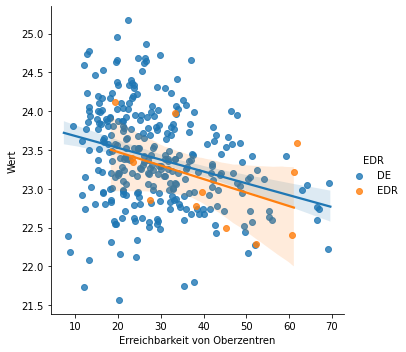

In [ ]:
sns.lmplot(data=ind_export, x=kategorie_indikator, y='Wert', order=1, hue='EDR',x_jitter=1) #x_bins=10, 

In [ ]:
pd.crosstab(ind_export['group'],ind_export['Klasse'])#,values=ind_export['Wert'], aggfunc=np.mean)

Klasse,0,1,2,3,4
group,,,,,
DE Oberzentrum,1,0,0,0,0
DE Rest,1,111,111,56,24
EDR Rest,0,1,4,3,4


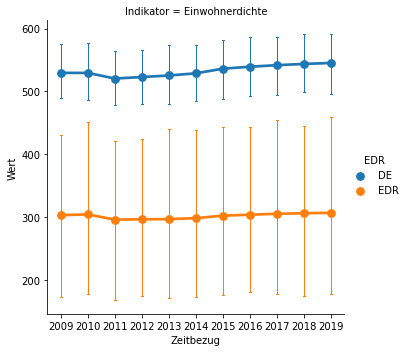

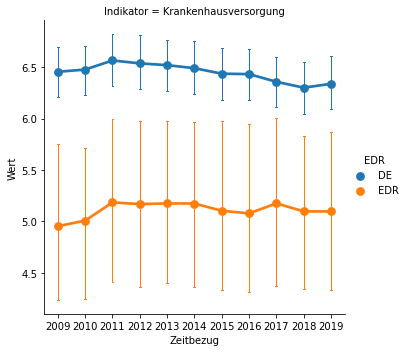

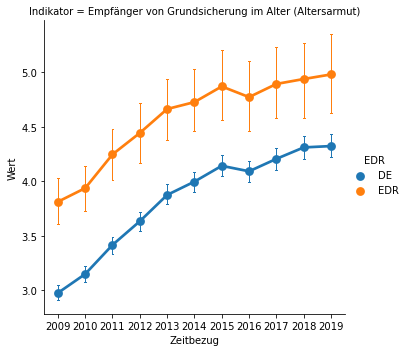

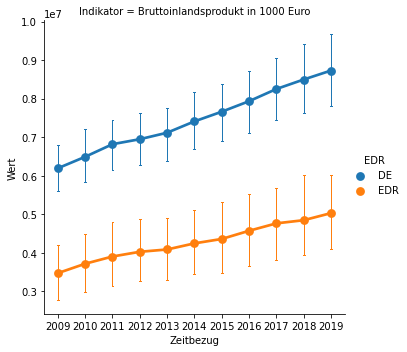

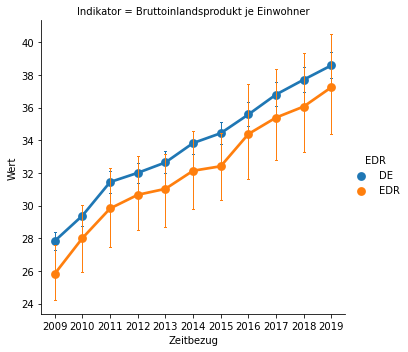

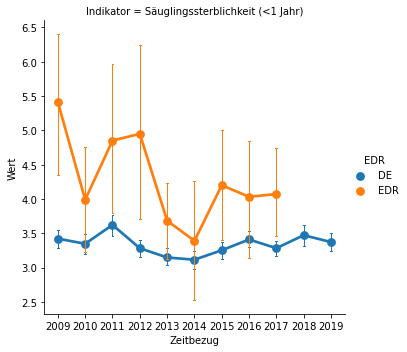

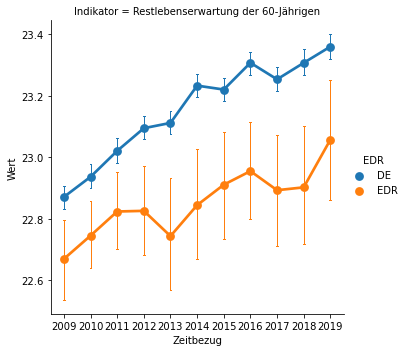

In [ ]:
for i in indikatoren:
        #sns.color_palette("Set2")
        p = sns.catplot(data=ind[(ind.Indikator==i)&(ind.Jahresnummer>2008)&((ind.Raumbezug=='Kreise')|(ind.Raumbezug=='Gemeinden')|(ind.Raumbezug=='Gemeindeverbände'))], #(ind.Indikator==indikatoren[1])&(ind.Raumbezug=='Kreise')&
                x='Zeitbezug', y='Wert', kind="point", sharey=False, #point
                row="Indikator", #col="EDR",
                hue='EDR', #EDR #group
                markers="o", errwidth=1 , capsize=.07, ci=80)
        p.savefig("grob_"+i.replace("<","")+".png")

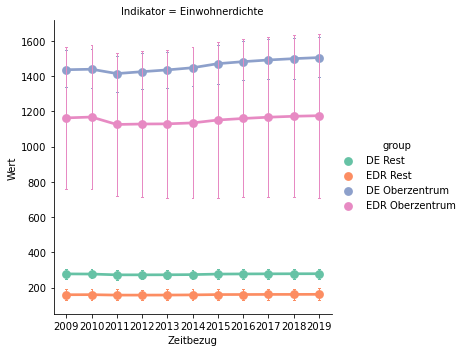

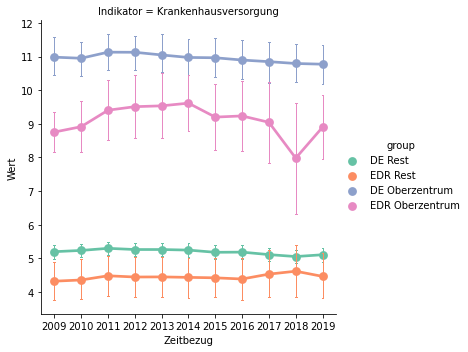

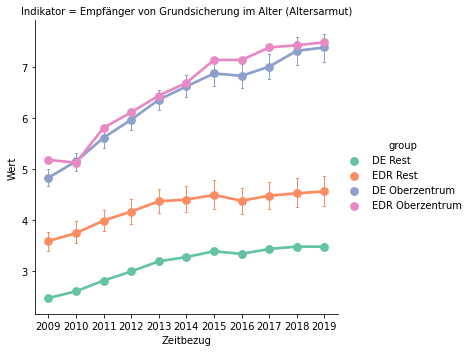

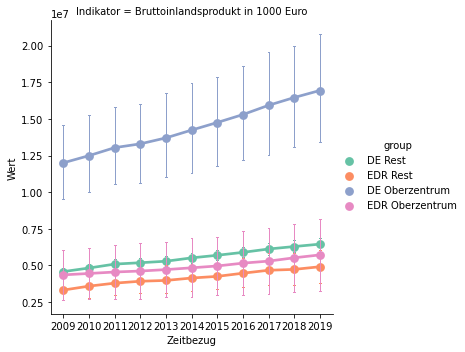

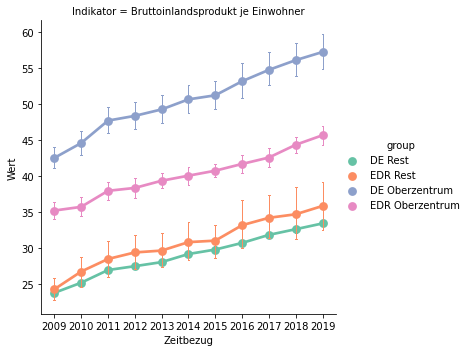

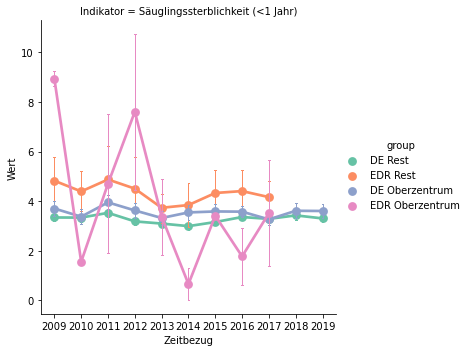

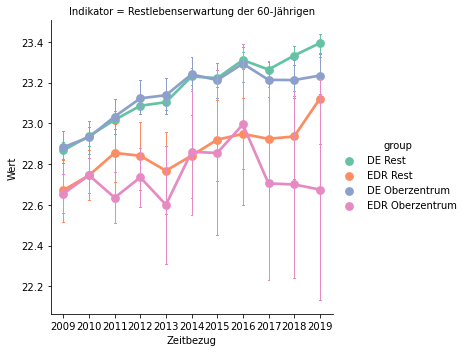

In [ ]:
for i in indikatoren:
        p = sns.catplot(data=ind[(ind.Indikator==i)&(ind.Jahresnummer>2008)&((ind.Raumbezug=='Kreise')|(ind.Raumbezug=='Gemeinden')|(ind.Raumbezug=='Gemeindeverbände'))], #(ind.Indikator==indikatoren[1])&(ind.Raumbezug=='Kreise')&
                x='Zeitbezug', y='Wert', kind="point", sharey=False, #point
                row="Indikator", #col="EDR",
                hue='group', #EDR #group
                markers="o", errwidth=1 , capsize=.07, ci=80, palette="Set2", hue_order=["DE Rest","EDR Rest","DE Oberzentrum","EDR Oberzentrum"])
        p.savefig("differenziert_"+i.replace("<","")+".png")

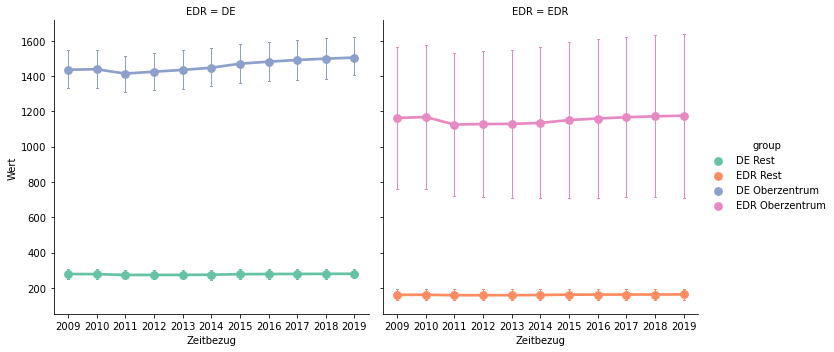

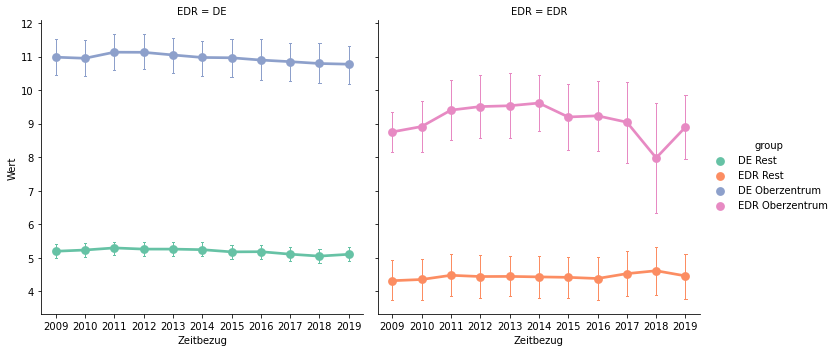

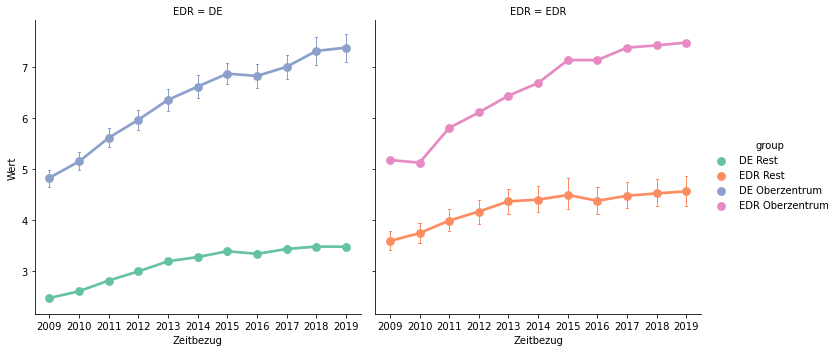

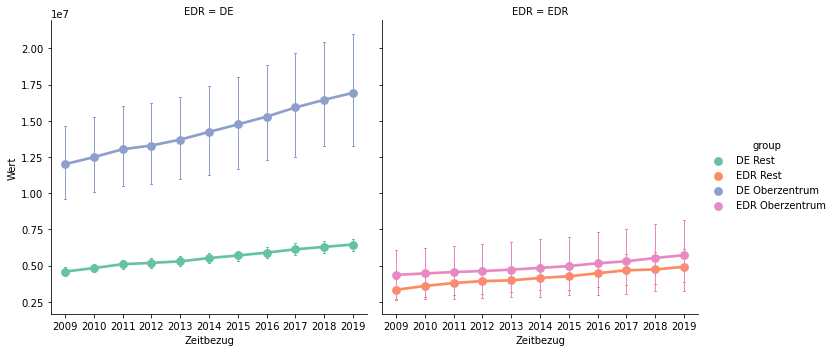

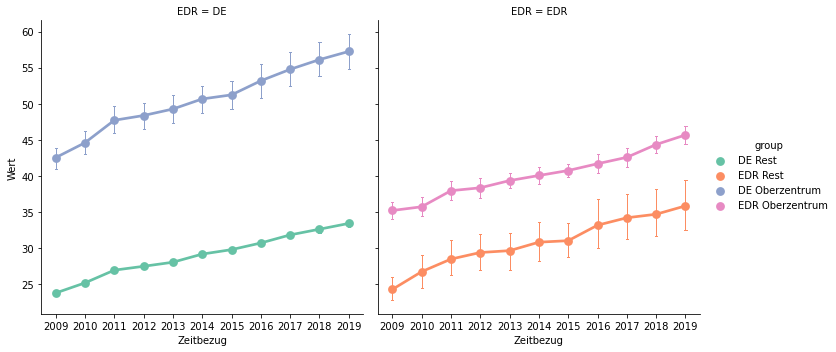

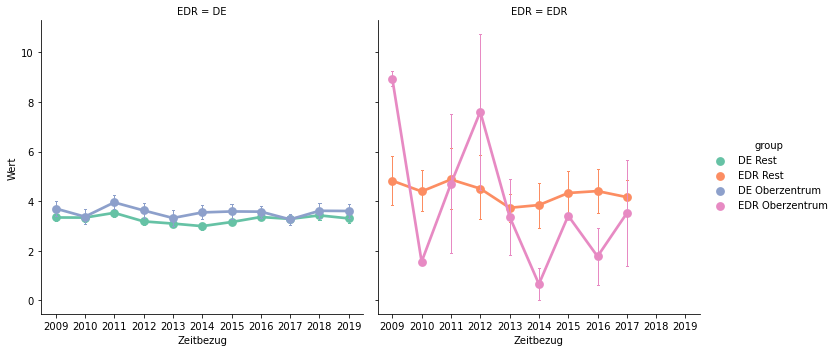

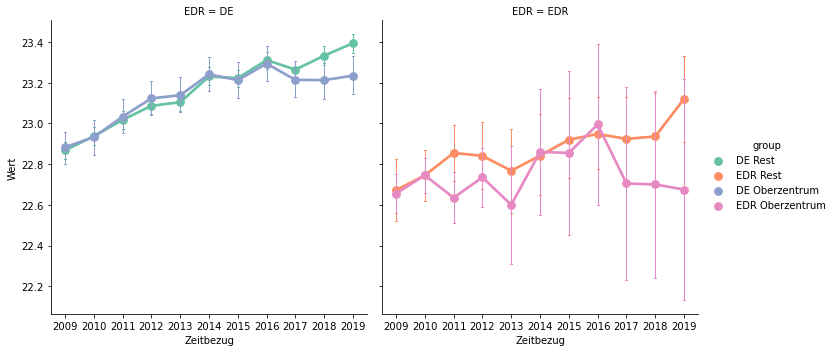

In [ ]:
for i in indikatoren:
        p = sns.catplot(data=ind[(ind.Indikator==i)&(ind.Jahresnummer>2008)&((ind.Raumbezug=='Kreise')|(ind.Raumbezug=='Gemeinden')|(ind.Raumbezug=='Gemeindeverbände'))], #(ind.Indikator==indikatoren[1])&(ind.Raumbezug=='Kreise')&
                x='Zeitbezug', y='Wert', kind="point", sharey=True, #point
                #row="Indikator",
                col="EDR",
                hue='group', #EDR #group
                markers="o", errwidth=1 , capsize=.07, ci=80, palette="Set2", hue_order=["DE Rest","EDR Rest","DE Oberzentrum","EDR Oberzentrum"])
        p.savefig("gruppiert_"+i.replace("<","")+".png")

In [ ]:
slice = ind[ind.Jahresnummer==2017]
pd.crosstab(slice['Indikator'],slice['group'], margins=True)

group,DE Oberzentrum,DE Rest,EDR Oberzentrum,EDR Rest,All
Indikator,,,,,
Arbeitslosenquote,85,303,2,12,402
Bruttoinlandsprodukt in 1000 Euro,85,303,2,12,402
Bruttoinlandsprodukt je Erwerbstätigen,85,303,2,12,402
Fortzugsrate,85,303,2,12,402
Restlebenserwartung der 60-Jährigen,85,303,2,12,402
SGB II - Quote,85,303,2,12,402
Schulabgänger ohne Abschluss,170,606,4,24,804
Säuglingssterblichkeit (<1 Jahr),85,303,2,12,402
Zuzugsrate,85,303,2,12,402


In [ ]:

p = sns.heatmap(data=ind[(ind.Jahresnummer>2008)&((ind.Raumbezug=='Kreise')|(ind.Raumbezug=='Gemeinden')|(ind.Raumbezug=='Gemeindeverbände'))], #(ind.Indikator==indikatoren[1])&(ind.Raumbezug=='Kreise')&
        x='Zeitbezug', y='Wert', kind="point", sharey=False,
        row="Indikator", #col="selected",
        hue='EDR', 
        markers="o", errwidth=1 , capsize=.07, ci=80)

ValueError: could not convert string to float: 'Absolutzahlen'

In [ ]:
p.savefig("ups.svg")

In [ ]:
# erzeuge Exceltabelle mit Indikator_Raumbezug

with pd.ExcelWriter("datenauswahl.xlsx") as writer:
    for r in (geo_codes['Raumbezug'].unique()):
        geo_codes[geo_codes['Raumbezug']==r].to_excel(writer, sheet_name=r[0:30], index=False)

In [ ]:
inkar.pivot_table(values="Zeitbezug", index="Indikator", columns="Raumbezug", aggfunc=np.count_nonzero)

In [ ]:
inkar.Bereich.unique()

In [ ]:
inkar.Indikator.unique()

## Ist die EDR in bestimmen Indikatoren unterschiedlich vom Rest?

[Der gute Lovi]( https://www.youtube.com/watch?v=xk3qlX37mvA)

H1: Die Werte im EDR sind im Mittel höher oder niedriger als die Werte im Rest der Bundesrepublik.

H0: Die Werte im EDR sind im Mittel ähnlich der Werte im Rest der Bundesrepublik.

(Zweiseitiger Test, p=X.X)

Ziel: Akzeptieren der Hypothese H1.

|                                                | HO stimmt     | H1 stimmt     |
| ---------------------------------------------- | ------------- | ------------- |
| Indizien sprechen für H0 -> H0 nicht abgelehnt | OK            | Fehler 2. Art* |
| Indizien sprechen gegen H0 -> H0 abgelehnt     | Fehler 1. Art | OK            |

\* Datenlage schwach

Mit welcher Wahrscheinlichkeit (p-Wert, "Indiz") sieht man Messwerte zur Ablehnung von H0 führen? Dazu muss der p-Wert klein sein (kleiner Signifikanzniveau).